# CNN

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sawyer","key":"6b6b255e589c9a607927b292afc085d3"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                      title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                           Apple Quality                               170KB  2024-01-11 14:31:07           3434         82  1.0              
hummaamqaasim/jobs-in-data                               Jobs and Salaries in Data Science            76KB  2023-12-25 20:03:32           9791        195  1.0              
fekihmea/sales-store-overview                            Sales Store overview                          2KB  2024-01-20 11:10:10            839         22  1.0              
shashwatwork/depression-and-mental-health-data-analysis  Depression and Mental Health Data Analysis    7KB  2024-01-14 16:24:08        

In [8]:
! kaggle datasets download -d alxmamaev/flowers-recognition

 95% 214M/225M [00:02<00:00, 106MB/s]
100% 225M/225M [00:02<00:00, 102MB/s]


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('flowers-recognition.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [10]:
!pip install split-folders

In [13]:
import splitfolders

splitfolders.ratio('./flowers', output="./flowers_split_data", seed=1337, ratio=(0.7, 0.15, 0.15))


Copying files: 4317 files [00:04, 905.71 files/s] 


In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from PIL import Image

# Set the path to the dataset folder
data_path = "./flowers_split_data"

# Create data generators for training and test
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Test the model on a few samples
test_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "test"),
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 3019 images belonging to 5 classes.
Found 644 images belonging to 5 classes.
Found 654 images belonging to 5 classes.


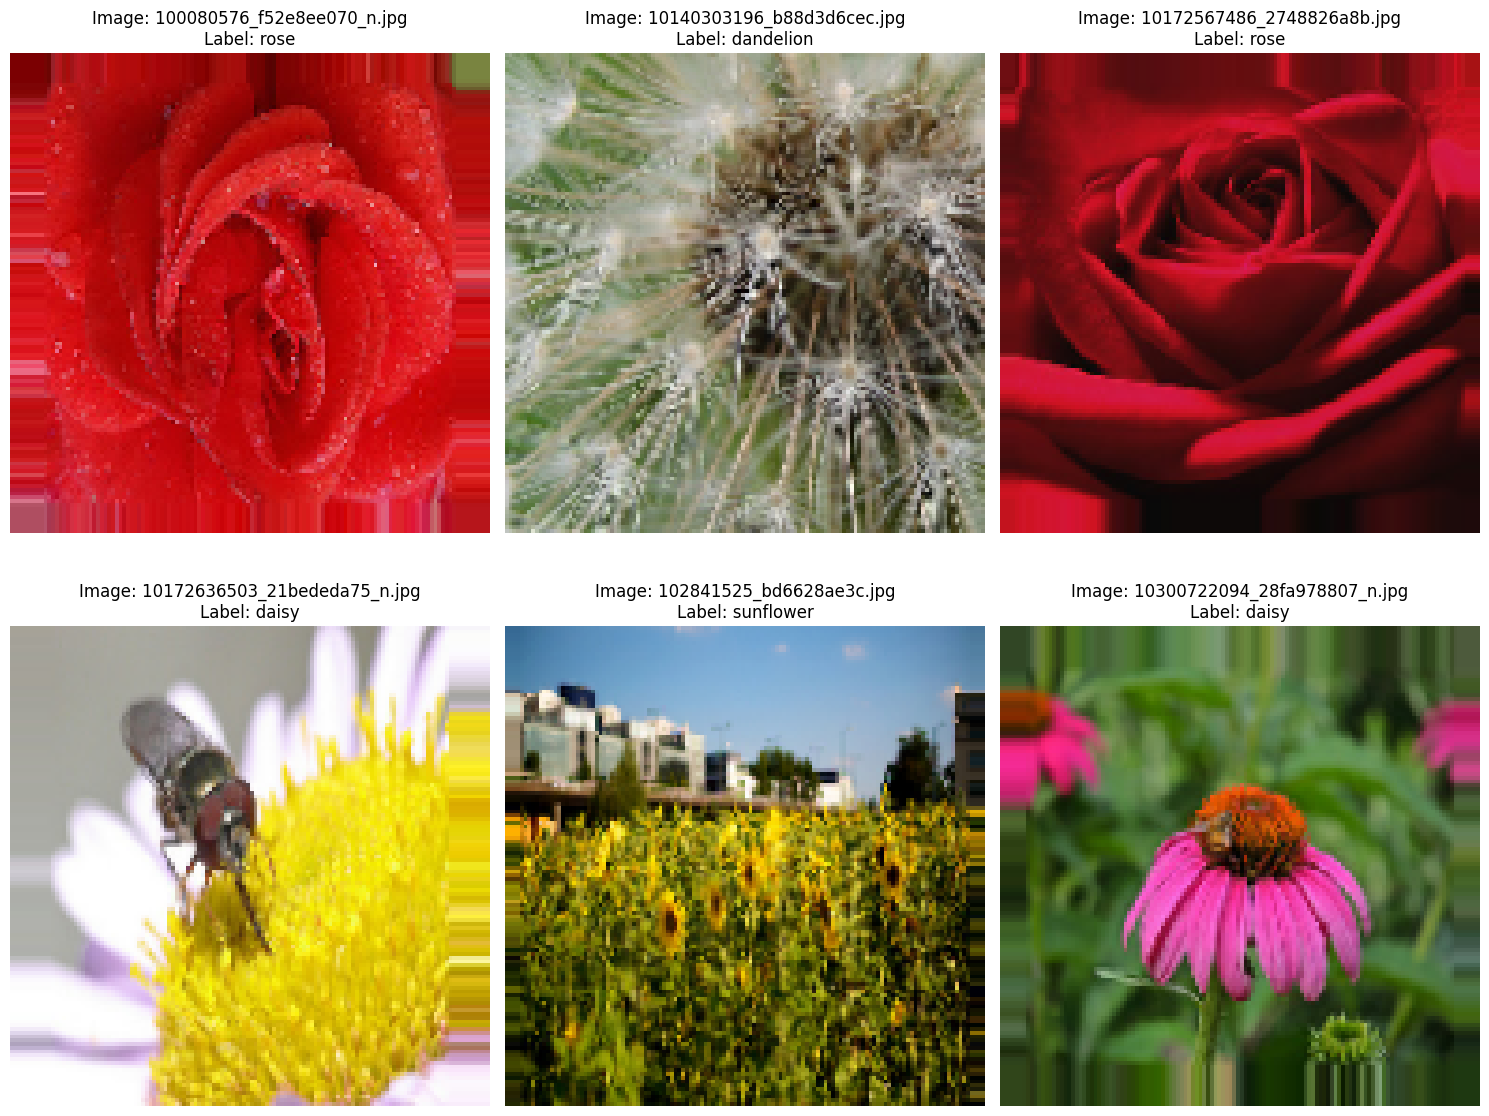

In [15]:
# Get the class indices mapping (class labels to class names)
class_indices = train_generator.class_indices

# Display 6 sample images from the training set along with their filenames and training labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, label = train_generator.next()
    img_filename = train_generator.filenames[train_generator.batch_index - 1]  # Get the filename of the current image
    img_class = list(class_indices.keys())[list(class_indices.values()).index(label[0].argmax())]  # Get the class name
    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nLabel: {img_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps and add fully connected layers
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=5, activation="softmax"))  # 5 flower classes in this dataset

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [18]:
!pip install pydot

In [19]:
!pip install graphviz

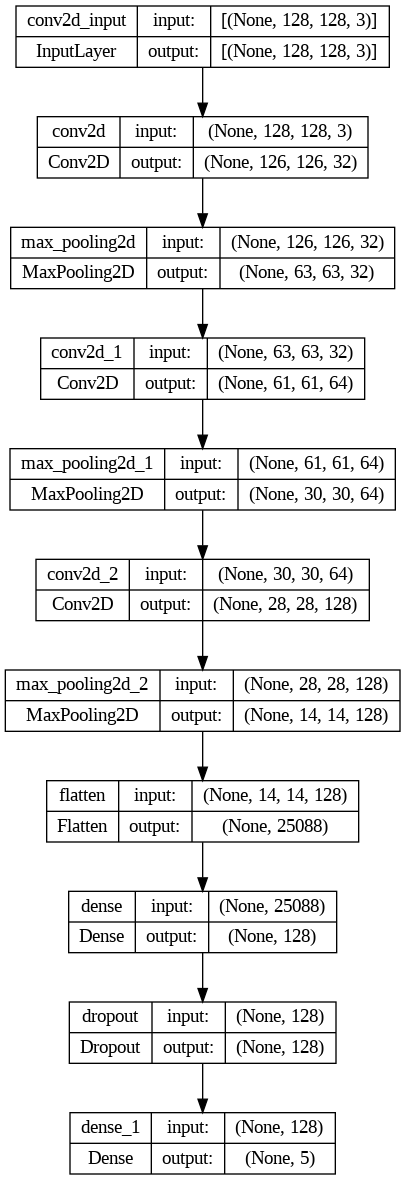

In [20]:
from keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [21]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 8.2 MB/s eta 0:00:00


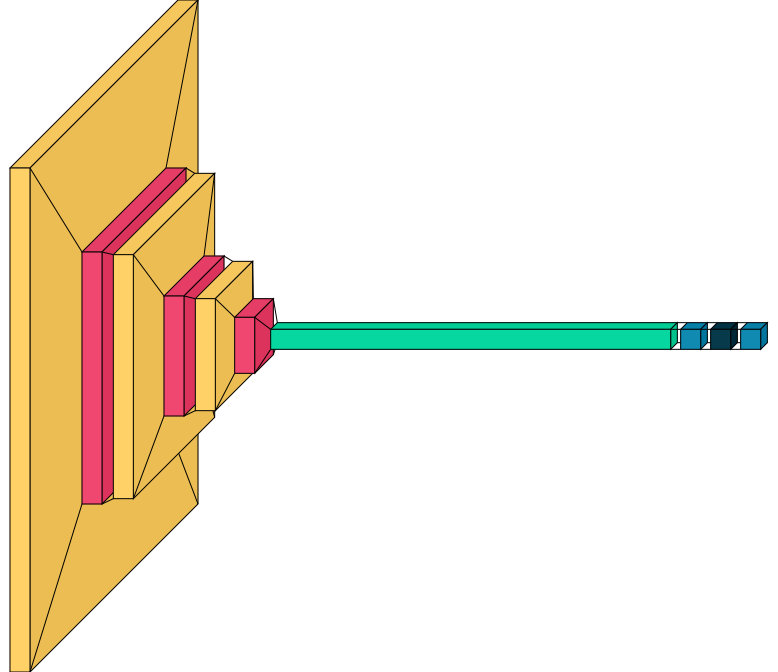

In [22]:
import visualkeras
visualkeras.layered_view(model)

In [23]:
# Define a checkpoint to save the best model
checkpoint = ModelCheckpoint("best_cnn_flower_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 1.3938 - accuracy: 0.3730
Epoch 1: val_accuracy improved from -inf to 0.47671, saving model to best_cnn_flower_model.h5
95/95 [==============================] - 108s 1s/step - loss: 1.3938 - accuracy: 0.3730 - val_loss: 1.1613 - val_accuracy: 0.4767


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 1.1679 - accuracy: 0.4955
Epoch 2: val_accuracy improved from 0.47671 to 0.53261, saving model to best_cnn_flower_model.h5
95/95 [==============================] - 123s 1s/step - loss: 1.1679 - accuracy: 0.4955 - val_loss: 1.1592 - val_accuracy: 0.5326
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 1.0867 - accuracy: 0.5605
Epoch 3: val_accuracy improved from 0.53261 to 0.55590, saving model to best_cnn_flower_model.h5
95/95 [==============================] - 120s 1s/step - loss: 1.0867 - accuracy: 0.5605 - val_loss: 1.1212 - val_accuracy: 0.5559
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 1.0105 - accuracy: 0.5856
Epoch 4: val_accuracy improved from 0.55590 to 0.63820, saving model to best_cnn_flower_model.h5
95/95 [==============================] - 110s 1s/step - loss: 1.0105 - accuracy: 0.5856 - val_loss: 0.9317 - val_accuracy: 0.6382
Epoch 5/50
95/95 [===================

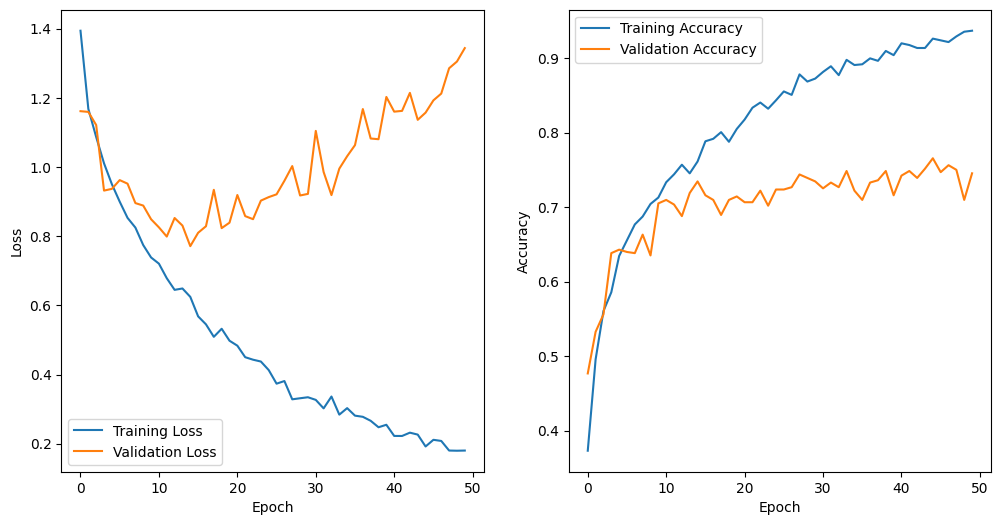

In [24]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

654/654 [==============================] - 9s 13ms/step


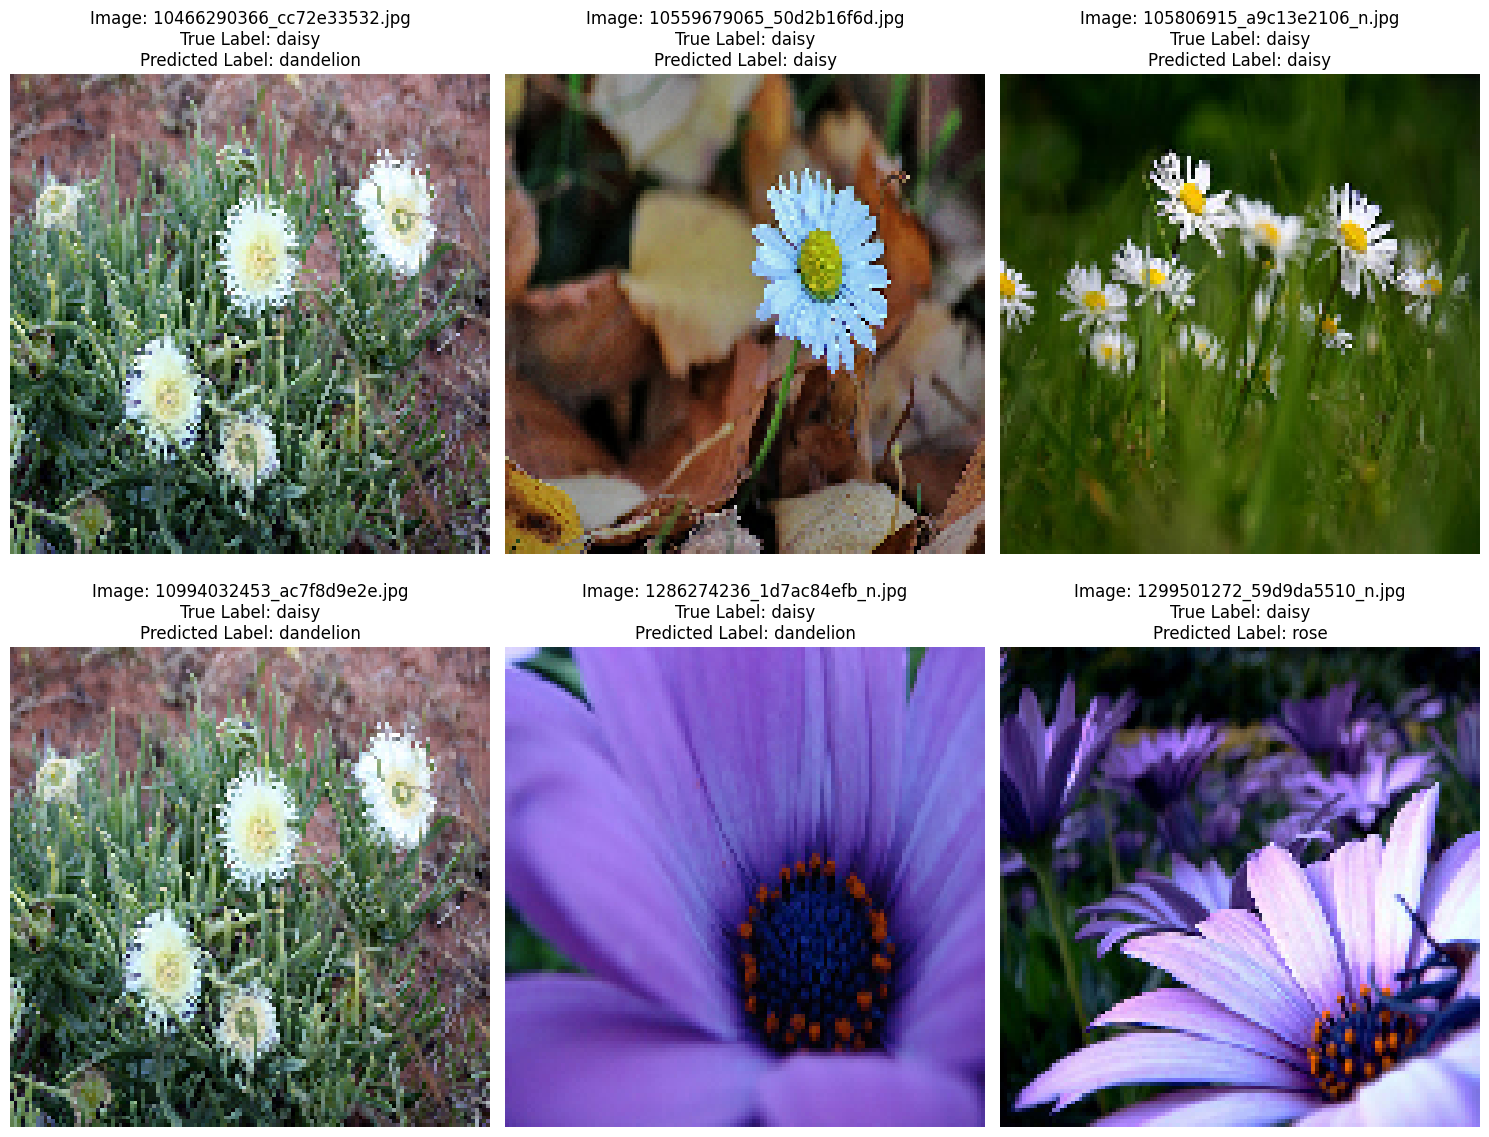

In [25]:
# Predict on the test set
predictions = model.predict(test_generator)

# Display some sample images from the test set along with their true and predicted labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, true_label = test_generator.next()
    img_filename = test_generator.filenames[test_generator.batch_index - 1]  # Get the filename of the current image
    true_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(true_label.argmax())]  # Get the true class name
    predicted_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(predictions[i].argmax())]  # Get the predicted class name

    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nTrue Label: {true_class}\nPredicted Label: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

654/654 [==============================] - 9s 13ms/step - loss: 1.2056 - accuracy: 0.7676
Test Loss: 1.2056
Test Accuracy: 0.7676


In [27]:
from keras.models import load_model
import tensorflow as tf

img_height=128
img_width=128

# Load the best model saved during training
model = load_model("./best_cnn_flower_model.h5")

# Direct link to the image file
img_url = "https://raw.githubusercontent.com/Ishasharmax/FlowerClassificationCNN/main/flowersData/dandelion/130733200_fbe28eea19.jpg"
# Download the image and get the local path
img_path = tf.keras.utils.get_file('130733200_fbe28eea19.jpg', origin=img_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

# Now, you can pass this 'image' to the model for prediction:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

print(f"Predicted Label: {class_names[np.argmax(score)]}")
print(f"Percent Confidence: {100 * np.max(score):.2f}%")

1/1 [==============================] - 0s 31ms/step
Predicted Label: dandelion
Percent Confidence: 40.46%


In [28]:
import numpy as np
import tensorflow as tf
from keras.models import load_model

img_height = 128
img_width = 128

# Load the best model saved during training
model = load_model("./best_cnn_flower_model.h5")

# Load and preprocess the image
image_path = "./flowers_split_data/test/daisy/488202750_c420cbce61.jpg"

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

print(
    "This image most likely belongs to {} with a {:.2f} % confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 92ms/step
This image most likely belongs to daisy with a 40.46 % confidence.


# CNN&Attention Model

In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, multiply, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from PIL import Image

In [30]:
# Set the path to the dataset folder
data_path = "./flowers_split_data"

# Create data generators for training and test
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Test the model on a few samples
test_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "test"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3019 images belonging to 5 classes.
Found 644 images belonging to 5 classes.
Found 654 images belonging to 5 classes.


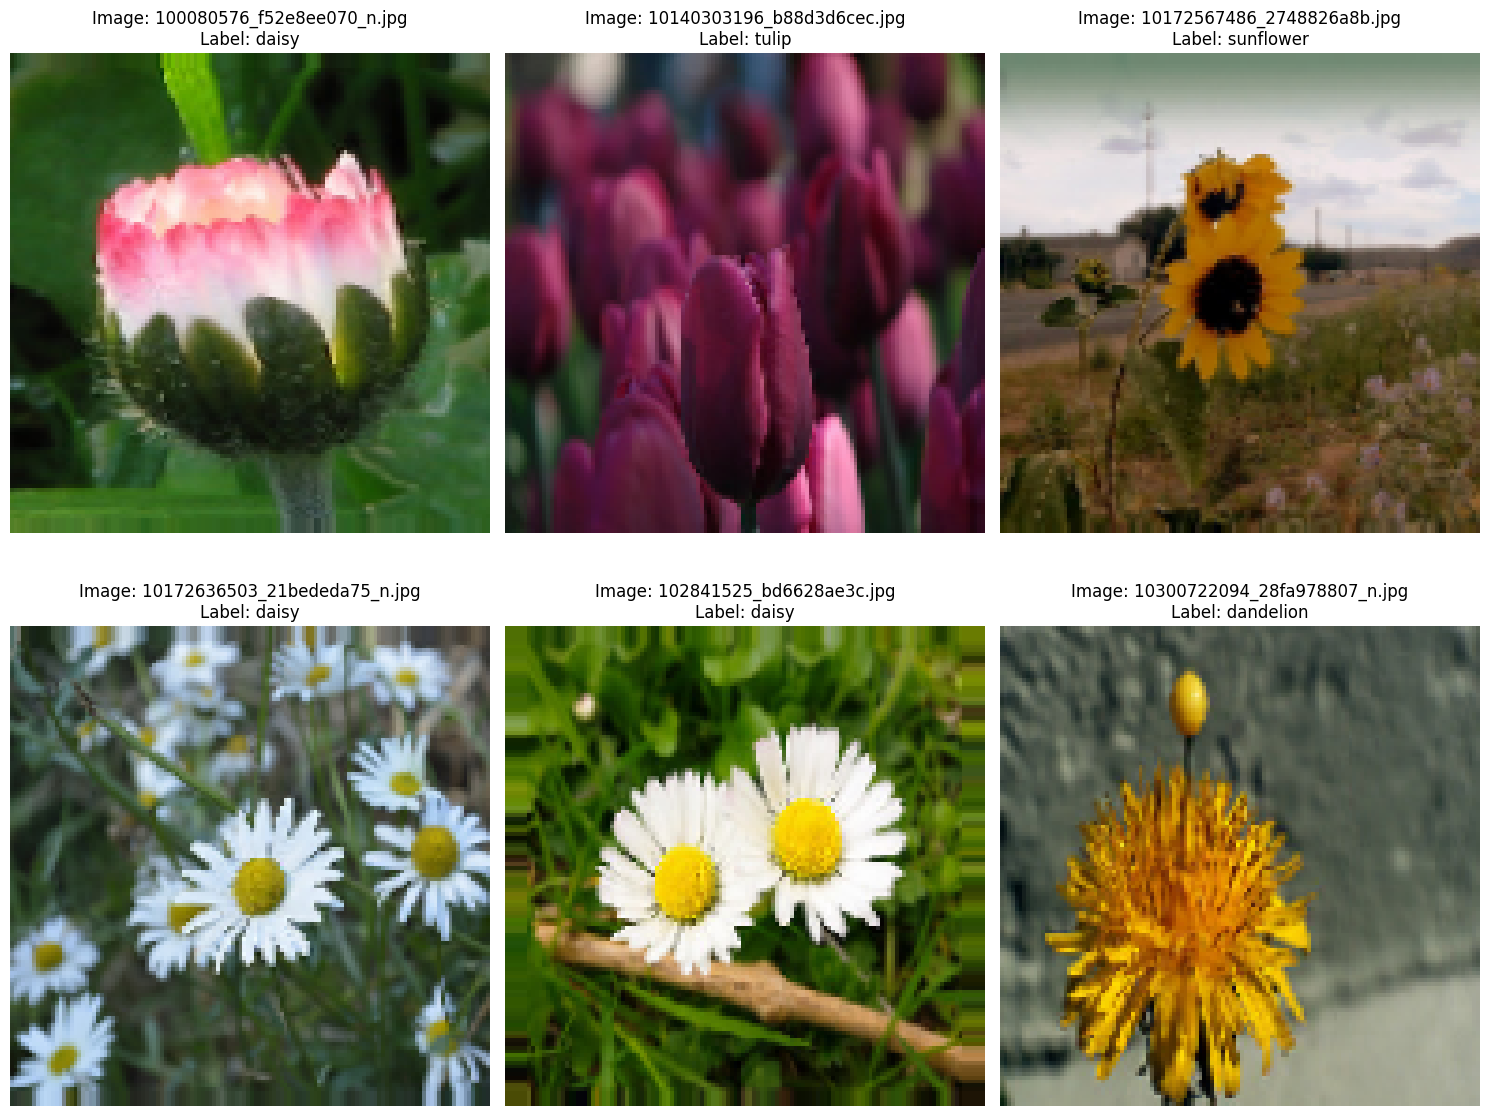

In [31]:
# Get the class indices mapping (class labels to class names)
class_indices = train_generator.class_indices

# Display 6 sample images from the training set along with their filenames and training labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, label = train_generator.next()
    img_filename = train_generator.filenames[train_generator.batch_index - 1]  # Get the filename of the current image
    img_class = list(class_indices.keys())[list(class_indices.values()).index(label[0].argmax())]  # Get the class name
    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nLabel: {img_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
# Create a CNN model with attention mechanism
input_img = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)

# Add Attention Layer
attention = Conv2D(1, (1, 1), activation='sigmoid')(x)
x = multiply([x, attention])

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)  # 5 classes for flower recognition

model = Model(inputs=input_img, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 126, 126, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 dropout_1 (Dropout)         (None, 63, 63, 32)           0         ['max_pooling2d_3[0][0]'] 

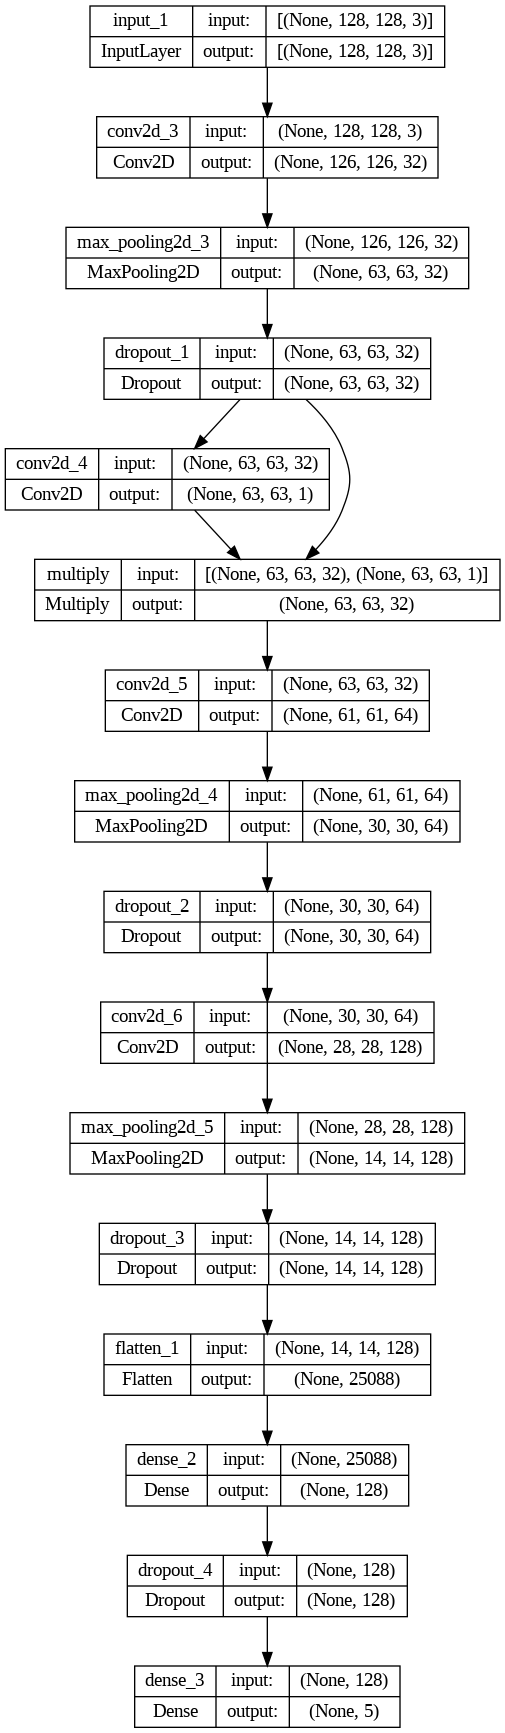

In [34]:
from keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

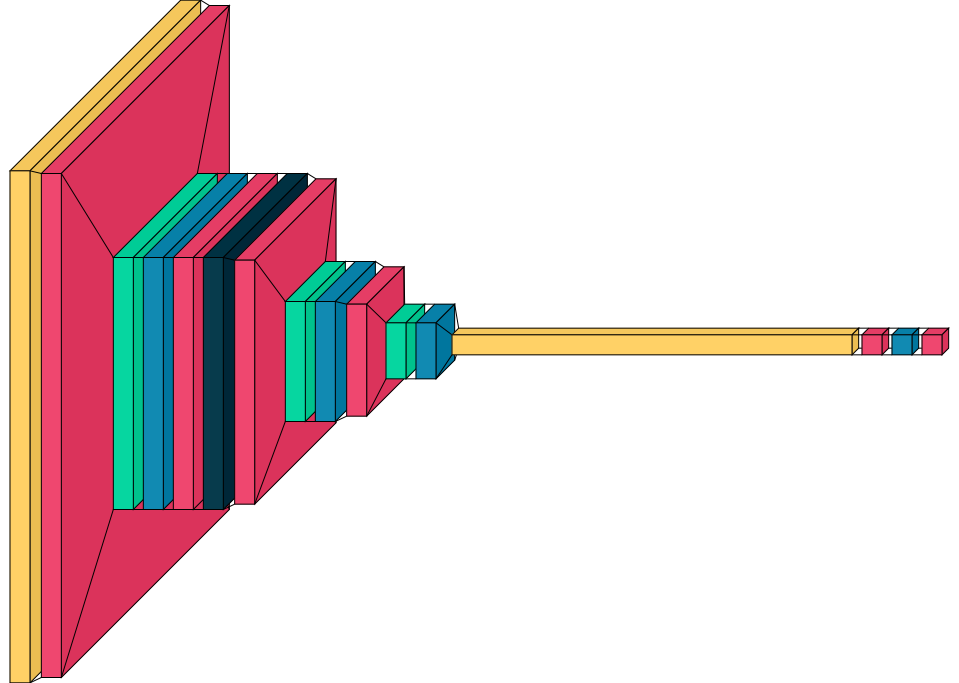

In [40]:
import visualkeras
visualkeras.layered_view(model)

In [35]:
# Define callbacks for model checkpoint, reduce learning rate and early stopping
checkpoint = ModelCheckpoint("./model/best_cnn_attention_flower.h5",
                             monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=5,
                              min_lr=0)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=15, verbose=1,
                               restore_best_weights=True,
                               mode='max')

In [36]:
import timeit
start_time = timeit.default_timer()
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[checkpoint,reduce_lr,early_stopping]  # Use the checkpoint to save the best model
)
elapsed = timeit.default_timer() - start_time
print("Total time: ", elapsed, "seconds")

Epoch 1/100
95/95 [==============================] - ETA: 0s - loss: 1.3992 - accuracy: 0.3760
Epoch 1: val_accuracy improved from -inf to 0.49379, saving model to ./model/best_cnn_attention_flower.h5
95/95 [==============================] - 111s 1s/step - loss: 1.3992 - accuracy: 0.3760 - val_loss: 1.1967 - val_accuracy: 0.4938 - lr: 0.0010
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 1.2089 - accuracy: 0.4819
Epoch 2: val_accuracy improved from 0.49379 to 0.52484, saving model to ./model/best_cnn_attention_flower.h5
95/95 [==============================] - 110s 1s/step - loss: 1.2089 - accuracy: 0.4819 - val_loss: 1.1506 - val_accuracy: 0.5248 - lr: 0.0010
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 1.1656 - accuracy: 0.5230
Epoch 3: val_accuracy improved from 0.52484 to 0.54348, saving model to ./model/best_cnn_attention_flower.h5
95/95 [==============================] - 110s 1s/step - loss: 1.1656 - accuracy: 0.5230 - val_loss: 1.124

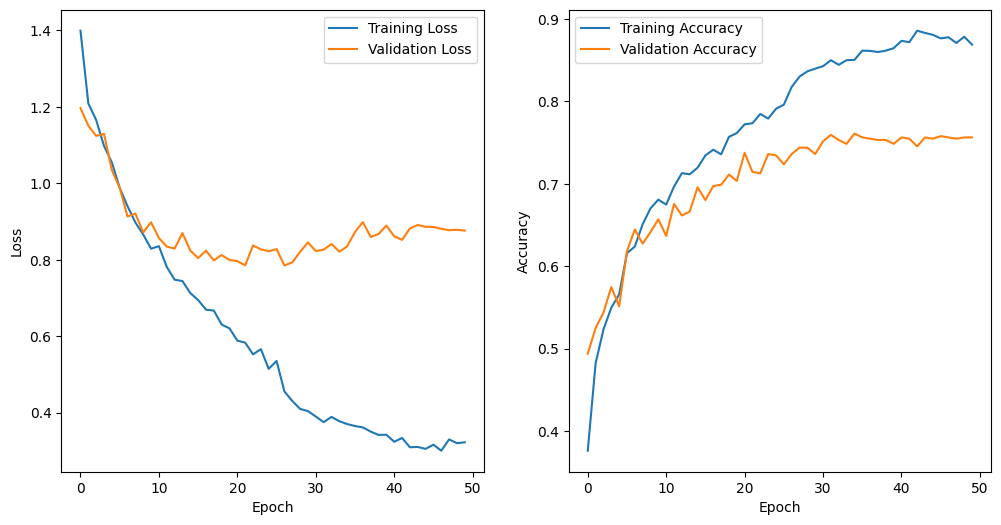

In [37]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

21/21 [==============================] - 6s 254ms/step


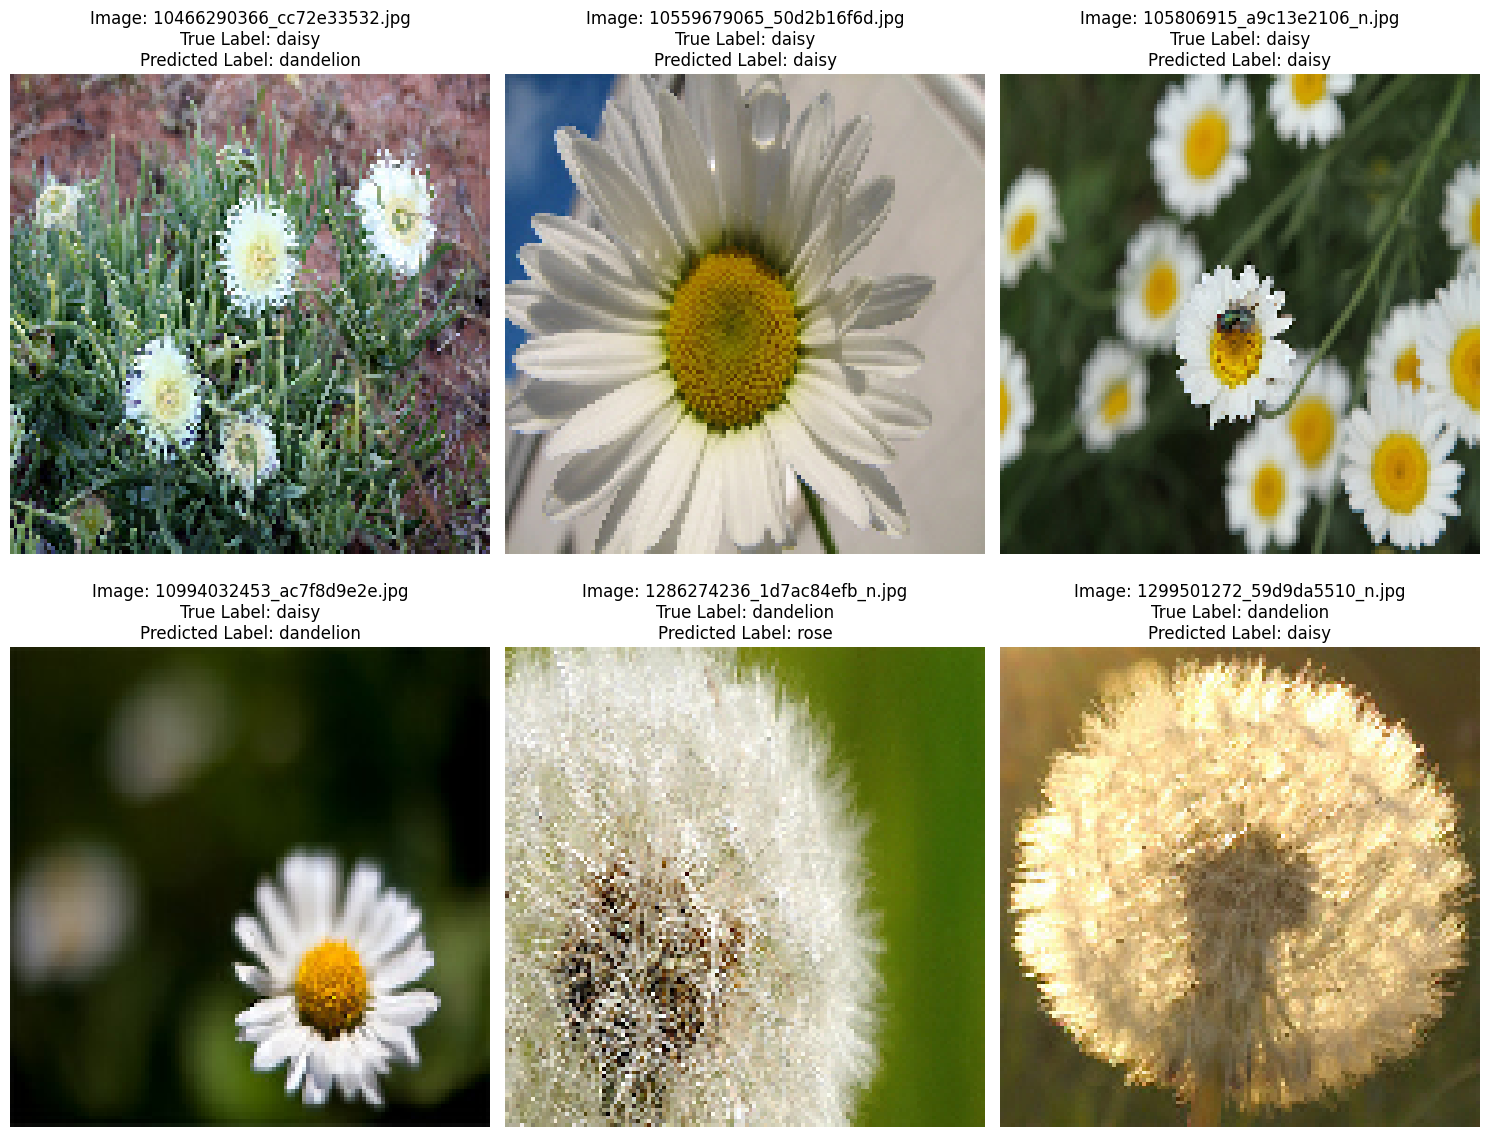

In [38]:
# Predict on the test set
predictions = model.predict(test_generator)

# Display some sample images from the test set along with their true and predicted labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, true_label = test_generator.next()
    img_filename = test_generator.filenames[test_generator.batch_index - 1]  # Get the filename of the current image
    true_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(true_label.argmax())]  # Get the true class name
    predicted_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(predictions[i].argmax())]  # Get the predicted class name

    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nTrue Label: {true_class}\nPredicted Label: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [39]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

21/21 [==============================] - 6s 263ms/step - loss: 0.7144 - accuracy: 0.7661
Test Loss: 0.7144
Test Accuracy: 0.7661
